### Contexto
Hoje em dia, redes sociais e publicações giram em torno de alcance, engajamento e popularidade.

E como se consegue isso? Clickbait? Títulos intrigantes? Palavras-Chave?

### Objetivo
Nesse projeto, vamos analisar uma base de dados de publicações feitas na internet (todas em inglês) e dados de engajamento dessas publicações, e além disso utilizamos o Facebook GraphAPI para enriquecer a base com numeros quantitativos de compartilhamentos, reações (like por exemplo) e contagem de comentários.

### O que temos disponível, inspirações e Créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/datasets/szymonjanowski/internet-articles-data-with-users-engagement

- As bases contém posts no Facebook, com dados coletados entre 03/09/2019 a 04/11/2019
- As publicações são listadas como "Top Popularity" no site de vários publicadores conhecidos

### Expectativas Iniciais
Irei analisar possíveis padrões de postagem que possam tornar a publicação mais suscetível a ter engajamento alto. Tenho como hipótese que palavras-chave nos títulos e descrição possam ser decisivas para gerar engajamento na publicação.

### Bibliotecas

In [108]:
#Data processing
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

In [109]:
#Linear algebra
import numpy as np

In [110]:
#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
#Model Selection
from sklearn.model_selection import cross_val_score

In [112]:
#Imbalanced Set Tools
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

In [113]:
#Models
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
import joblib

In [114]:
#Text
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS
import re
import string

### Loading Data

In [115]:
#A base contém 10437 linhas e 14 colunas. As que iremos focar serão:
#Source name, Author, Top Articles, e as engagement features

df = pd.read_csv('articles_data.csv')
df.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


### Missing Values

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10437 non-null  int64  
 1   source_id                        10437 non-null  object 
 2   source_name                      10437 non-null  object 
 3   author                           9417 non-null   object 
 4   title                            10435 non-null  object 
 5   description                      10413 non-null  object 
 6   url                              10436 non-null  object 
 7   url_to_image                     9781 non-null   object 
 8   published_at                     10436 non-null  object 
 9   content                          9145 non-null   object 
 10  top_article                      10435 non-null  float64
 11  engagement_reaction_count        10319 non-null  float64
 12  engagement_comment

In [118]:
# Podemos notar que algumas colunas possuem muitos dados faltantes, então fiz essa tabela para melhor visualizar:

NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)
NA.style.background_gradient(cmap="summer", subset=['NA Count'])

,NA Count,NA Percent
content,1292,12.38%
author,1020,9.77%
url_to_image,656,6.29%
engagement_reaction_count,118,1.13%
engagement_comment_count,118,1.13%
engagement_share_count,118,1.13%
engagement_comment_plugin_count,118,1.13%
description,24,0.23%
title,2,0.02%
top_article,2,0.02%


In [119]:
#a maior parte dos dados faltantes está na coluna "content" e "author",
#porém acredito que possamos trabalhar esses dados mesmo com essas informações faltando.

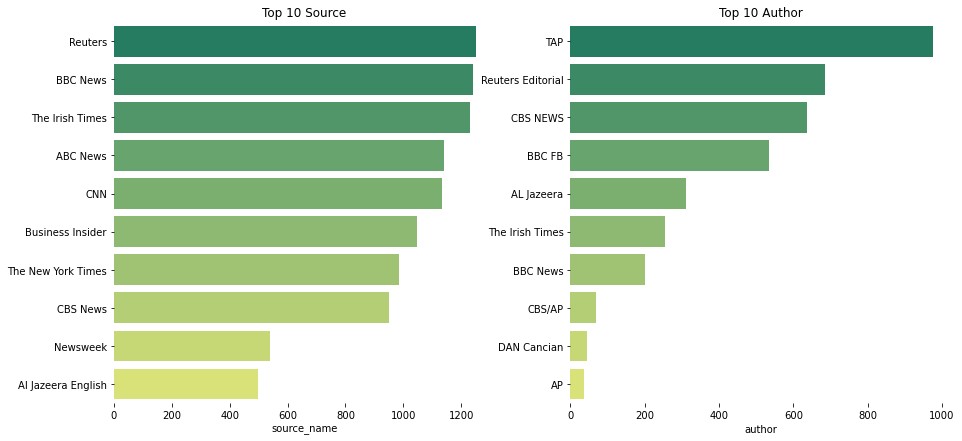

In [120]:
#aqui temos um gráfico dos "publishers" com maior contagem de publicações nesse dataframe.
#na esquerda, estão listados as top 10 fontes, e na direita, os top 10 autores.

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
source_name = df["source_name"].dropna().value_counts()[:10]
author = df["author"].dropna().value_counts()[:10]

yticklabels = ['TAP',
               'Reuters Editorial',
               'CBS NEWS',
               'BBC FB',
               'AL Jazeera',
               'The Irish Times',
               'BBC News',
               'CBS/AP',
               'DAN Cancian', 
               'AP']
sns.barplot(x=source_name,y=source_name.index,palette='summer',ax=ax1)
sns.barplot(x=author,y=author.index,palette='summer',ax=ax2 )
sns.despine(bottom=True,left=True)
ax1.set(title='Top 10 Source')
ax2.set(title='Top 10 Author')
ax2.set_yticklabels(yticklabels) ;

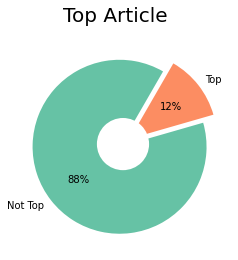

In [122]:
#Mostramos a distribuição entre publicações que estão marcadas como "Top Article" ou não.
#A feature "Top article" indica se uma publicação foi marcada no site como "Top Article" e pode receber valores de 1 para "sim" e 0 para "não".

fig, ax  = plt.subplots(figsize=(8, 4))
fig.suptitle('Top Article', size = 20, color = "black")
explode = ( 0.05, 0.1)
labels = ["Not Top","Top"]
sizes = df["top_article"].dropna().value_counts()
ax.pie(sizes, 
       explode=explode, 
       colors=sns.color_palette("Set2"),
       startangle=60,
       labels=labels,
       autopct='%1.0f%%',
       pctdistance=0.6)
ax.add_artist(plt.Circle((0,0),0.3,fc='white'))
plt.show()

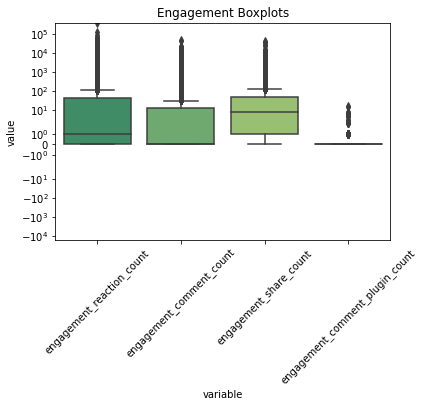

In [123]:
# para ver como estão distribuídas as features de engajamento, coloquei um boxplot com os números para cada feature.
#Isso pode indicar alguns outliers na quantidade, seja para mais ou para menos. Vemos que mesmo que algumas publicações
#possuam 0 engajamento, elas não são outliers para a distribuição de dados,
#porém algumas publicações performaram excepcionalmente melhor que outras, devemos manter atenção sobre essas.
eng = ['engagement_reaction_count',
       'engagement_comment_count',
       'engagement_share_count',
       'engagement_comment_plugin_count'] 
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df[eng]),palette='summer')
ax.set_title('Engagement Boxplots')
plt.xticks(rotation=45)
ax.set_yscale('Symlog')
plt.show()

In [126]:
#Para entender o que se passa na distribuição dos dados "engagement_comment_plugin":
#vemos que 99% dos dados contém ZERO nessa feature. Possível motivo para dropar a coluna, porém ainda faremos mais análises.

pd.DataFrame(df["engagement_comment_plugin_count"].\
             value_counts().\
             reset_index().\
             rename(columns = {'index':'engagement_comment_plugin',
                               'engagement_comment_plugin_count':'Counts'})).\
            astype(int).\
            style.background_gradient(cmap="summer", subset=['Counts'])

,engagement_comment_plugin,Counts
0,0,10269
1,1,32
2,2,8
3,6,2
4,8,2
5,3,2
6,15,1
7,5,1
8,4,1
9,14,1


### Analisando os Títulos

In [127]:
#visualizando os 5 primeiros dados da coluna "title" 
df['title'][0:5]

0    NTSB says Autopilot engaged in 2018 California...
1         Unemployment falls to post-crash low of 5.2%
2    Louise Kennedy AW2019: Long coats, sparkling t...
3    North Korean footballer Han joins Italian gian...
4    UK government lawyer says proroguing parliamen...
Name: title, dtype: object

In [128]:
#iremos definir uma função que remova todos os tipos de pontuação e caracteres que não sejam letras.
#Isso ajudará quando formos treinar o modelo, para identificar apenas palavras e dar uma pontuação para elas.

def clean_title(x:str):    
    # Deixando o testo em letras minúsculas
    x=x.lower() 
 
    #Removendo caracteres não alfa-numéricos
    x = re.sub('\[.*?\]', '', x)
    x = re.sub('<.*?>+', '', x) 

    #Removendo hyperlinks
    x = re.sub('https?://\S+|www\.\S+', '', x) 

    ##Removendo outros sinais de pontuação
    x = re.sub('[%s]' % re.escape(string.punctuation), '', x) 
    x = re.sub('\n', '', x) 

    #Removendo números dentro de palavras
    x = re.sub('\w*\d\w*', '', x) 
    return x

In [129]:
df['clean_title'] = df['title'].astype(str).apply(clean_title) 
df['clean_title'][0:5]

0    ntsb says autopilot engaged in  california tes...
1              unemployment falls to postcrash low of 
2    louise kennedy  long coats sparkling tweed dre...
3    north korean footballer han joins italian gian...
4    uk government lawyer says proroguing parliamen...
Name: clean_title, dtype: object

In [130]:
#Utilizaremos o modelo "SentimentIntensityAnalyzer" para gerar uma pontuação para as frases e títulos:
#Basicamente o que o modelo faz é buscar palavras em seu dataset que denotem sentimentos positivos, negativos ou neutros,
#E a partir disso ele gera uma pontuação de -1 a 1 para a intensidade daquele sentimento.
#Entre dados entre -0.5 e 0.5 serão considerados com sentimento "nulo" enquanto suas extremidades (abaixo de -0.5 e acima de 0.5)
#serão considerados negativo ou positivo conforme o sinal.

analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

In [131]:
polarity_scores = df["clean_title"].astype("str").apply(compound_score)
df["Sentiment_Score"] = polarity_scores

In [132]:
df["Sentiment"] = df["Sentiment_Score"].apply(sentiment)

In [133]:
#Criamos então as colunas "Sentiment_Score" que irá mostrar a intensidade calculada pelo modelo, e 
#a coluna "Sentiment" que mostra a label que aquele sentimento possui ("Negative, Neutral, Positive")

df.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,clean_title,Sentiment_Score,Sentiment
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0,ntsb says autopilot engaged in california tes...,0.0000,Neutral
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0,unemployment falls to postcrash low of,-0.6124,Negative
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN,louise kennedy long coats sparkling tweed dre...,0.2960,Neutral
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0,north korean footballer han joins italian gian...,0.0000,Neutral
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0,uk government lawyer says proroguing parliamen...,-0.0951,Neutral


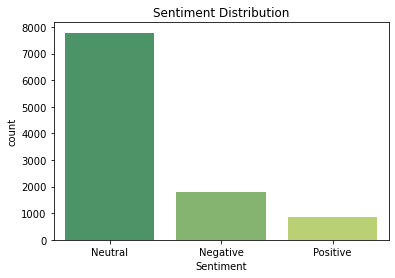

In [134]:
#E esta foi a distribuição dos sentimentos:

sns.countplot(data=df,x="Sentiment",palette="summer")
plt.title('Sentiment Distribution');

### Analise do texto

In [137]:
#aqui começaremos a analise das strings contidas nos textos.
#Primeiramente usamos a biblioteca STOPWORDS para nos auxiliar a desconsiderar palavras comuns, de interjeição,
#ou simplesmente necessárias para a elaboração gramatical da frase.
#A seguir no exemplo das 10 primeiras palavras da biblioteca:

np.array(list(STOPWORDS))[0:10]

array(['are', 'during', 'before', "where's", 'like', "you'll", 'for',
       'up', 'with', 'any'], dtype='<U10')

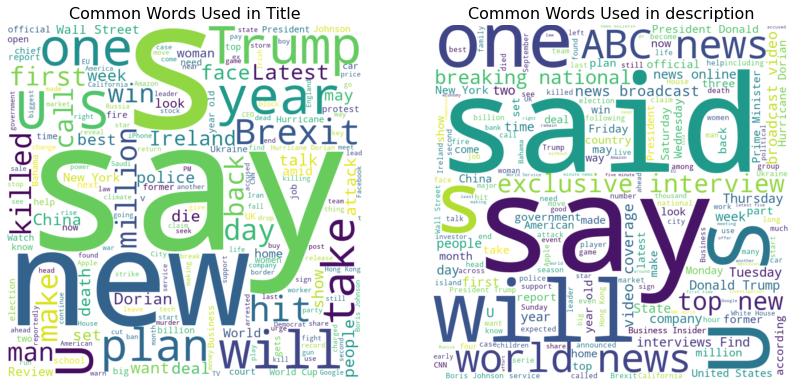

In [138]:
#Após ignorar essas palavras, montei uma WordCloud trazendo as palavras mais citadas nos títulos e nas descrições
#das publicações, para termos uma ideia inicial de quais palavras são as mais utilizadas ao elaborar tais títulos.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 14], facecolor = None)


wc = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True,stopwords = STOPWORDS)
wc.generate("".join(df['title'].astype(str)))
ax1.axis("off")
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title('Common Words Used in Title',fontsize=16);


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True,stopwords = STOPWORDS)
wc2.generate("".join(df['description'].astype(str)))
ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Common Words Used in description',fontsize=16);

In [139]:
df['published_at'] = pd.to_datetime(df['published_at'])

df['Day_Of_Week'] = df['published_at'].apply(lambda x: x.dayofweek)
df['Month'] = df['published_at'].apply(lambda x: x.month)
df['Year'] = df['published_at'].apply(lambda x: x.year)

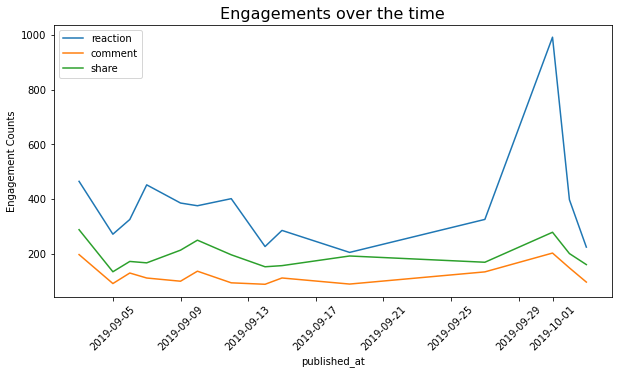

In [140]:
#Agora para visualizar dados em relação ao tempo, esse plot trás a contagem de engagement features ao longo dos dias
#Como podemos ver, no dia 29 de setembro tivemos um pico de reações em alguma postagem

fig, ax1 = plt.subplots( figsize=[10, 5], facecolor = None)

date_mean = df.copy()
date_mean['published_at'] = pd.to_datetime(date_mean['published_at']).dt.normalize()
date_mean = date_mean.groupby(by='published_at').mean().reset_index()

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_reaction_count",label = 'reaction'
)

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_comment_count",label = 'comment'
)

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_share_count", label = 'share'
)
plt.ylabel('Engagement Counts')
plt.xticks(rotation=45)
plt.title('Engagements over the time',fontsize=16);

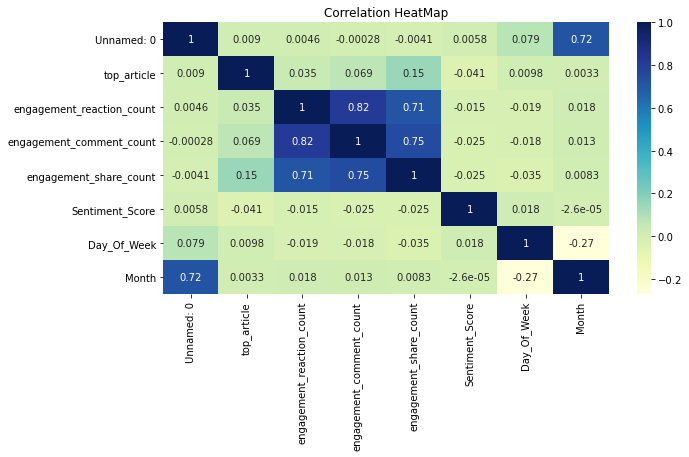

In [141]:
#Analisamos então a correlação entre os dados numéricos. Aqui o mais importante é a correlação entre "top article"
#e as outras features. A maior correlação nesse sentido é a de "engagement_share_count".

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(df.drop(columns = ['Year','engagement_comment_plugin_count']).corr(),
                       cmap="YlGnBu", annot=True)


ax.set_title('Correlation HeatMap',fontsize=12)  
plt.show()

In [143]:
#Agora vamos vetorizar os textos nos títulos. Para dados faltantes, apenas preencheremos com "Missing"
#Utilizando TfidVectorizer, vamos transformar os títulos em matrizes para poder quantificar valores para as palavras
#nos textos e treinar um modelo que utiliza números para fazer previsões.

df['clean_title'].fillna('Missing',inplace=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            dtype=np.float32, 
                            sublinear_tf=True, 
                            use_idf=True, 
                            smooth_idf=True)
train_tfidf = tfidf_vec.fit_transform(df['clean_title'])

In [145]:
#Para os dados faltantes em "top_article", preencheremos com "0", 
#pois acredito que essas publicações não sejam "top_article" e apenas não foi preenchido ao extrair os dados.

list_labels = df["top_article"].fillna(0)
list_labels.value_counts()

0.0    9163
1.0    1274
Name: top_article, dtype: int64

In [148]:
#Como estamos trabalhando com dados desbalanceados, usaremos SMOTE para dar preferência aos dados com label 1.
#Isso impede que o modelo possa simplesmente prever que todos os dados são "Non_Top_Article (label 0)"
#E mesmo assim obter 87% de acertos (como é o caso dos nossos dados)

OS = SMOTE()
X,Y = OS.fit_resample(train_tfidf,list_labels)

In [151]:
#Para usarmos um modelo de regressão, vamos criar a coluna de "Popularity_Score" que basicamente soma as 4
#features de engajamento e usa uma base logarítmica para normalizar o número.

df['Popularity_Score'] = np.log1p((df['engagement_reaction_count'] + \
                         df['engagement_comment_count']+\
                         df['engagement_share_count']+\
                         df['engagement_comment_plugin_count']))

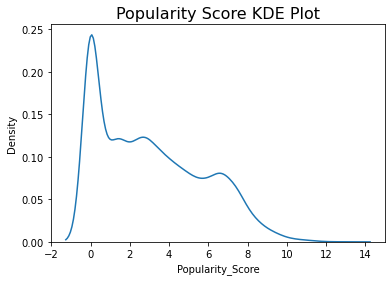

In [152]:
#A distribuição dos dados de "Popularity_Score" ficou assim:

sns.kdeplot(df['Popularity_Score'])
plt.title('Popularity Score KDE Plot',fontsize=16);

In [154]:
#E usando a média das pontuações para cada source_name(site publisher),
#temos um ranking dos sites com maior Popularity_Score.

df.groupby(by='source_name').\
    mean()['Popularity_Score'].\
    to_frame().\
    sort_values(by='Popularity_Score',
                ascending=False)

,Popularity_Score
source_name,
The New York Times,4.777518
CNN,4.418373
Business Insider,3.855361
Al Jazeera English,3.720652
The Wall Street Journal,3.499767
CBS News,3.163584
BBC News,2.929104
Newsweek,2.674136
Reuters,2.673019


In [156]:
#Para treinar nosso modelo, vamos usar o modelo lightGBM
#primeiro separamos nossos dados em treino e teste usando train_test_split
#E setamos alguns hyper-parâmetros para o nosso modelo de top articles

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.1,
                                                    stratify = Y ,
                                                    random_state=40)

modeltop = LGBMClassifier(verbose=-1,
                          learning_rate=0.5,
                          max_depth=20,
                          num_leaves=50, 
                          n_estimators=120,
                          max_bin=2000,)

In [158]:
#Para ter certeza que os dados estão colaborando corretamente para o treinamento, usarei o método de Cross Validation
#E apresento abaixo o score F1 de cada um dos 5 sets criados com validação cruzada:

scores = cross_val_score(
                 modeltop, X_train, y_train, cv=5, scoring='f1_macro')

print("Cross Validation F1 Scores : ",scores)

Cross Validation F1 Scores :  [0.90358411 0.90206332 0.89957429 0.90318028 0.90288575]


In [160]:
#Após a validação cruzada, treinamos o modelo e testamos, para saber sua precisão

modeltop.fit(X_train,y_train)

predtop = modeltop.predict(X_test)
print("f1 score : ",round(f1_score(predtop,y_test),2))
print("accuracy score : ",round(accuracy_score(predtop,y_test),2))

f1 score :  0.91
accuracy score :  0.91


In [161]:
#com 91% de acurácia, podemos considerar o modelo para previsão de label,
#dizendo se a publicação será ou não considerada um Top Article.
#Usaremos joblib para armazenar o modelo treinado.

In [162]:
joblib.dump(modeltop, 'lgb_top.pkl')

['lgb_top.pkl']

In [163]:
y_test.value_counts()

0.0    917
1.0    916
Name: top_article, dtype: int64

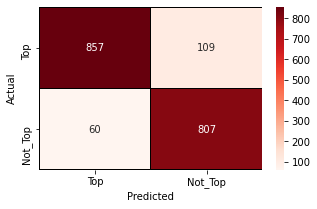

In [170]:
#Aqui veremos a confusion_matrix para saber se os dados estão se comportando como esperamos,
#ou seja, se os "True Positives" e os "True Negatives" são dominantes nos resultados de previsão do modelo.

plt.figure(figsize = (5,3))
cm = confusion_matrix(predtop, y_test)
sns.heatmap(cm,cmap= "Reds",
            linecolor = 'black' ,
            linewidth = 0.5 ,
            annot = True,
            fmt='' ,
            xticklabels = ['Top','Not_Top'] ,
            yticklabels = ['Top','Not_Top'])
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [174]:
#agora começaremos a prever o "Popularity_Score" de cada publicação.
#Para isso, preencheremos os dados faltantes na coluna com 1

list_labels = df["Popularity_Score"].fillna(1)

X_train, X_test, y_train, y_test = train_test_split(train_tfidf,
                                                    list_labels,
                                                    test_size=0.2,
                                                    random_state=40)

In [175]:
#Também utilizando o LightGBM, setamos alguns hiper-parâmetros que serão utilizados no nosso modelo de regressão

model1 = LGBMRegressor(verbose=-1,
                       learning_rate=0.01,
                       max_depth=20,
                       num_leaves=50,
                       n_estimators=150)

In [178]:
#Da mesma forma que anteriormente, usarei Cross Validation para ver 
#se os dados diferem muito quando mudamos a amostragem de treino e teste

scores = cross_val_score(
                 model1, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("Cross Validation RMSE Scores : ",-scores)

Cross Validation RMSE Scores :  [2.55957823 2.61835608 2.61620127 2.53990543 2.57260691]


In [179]:
#Com os Erros quadráticos bem parecidos, podemos seguir e treinar nosso modelo.
model1.fit(X_train,y_train)

pred1 = model1.predict(X_test)
print("RMSE: ",round(np.sqrt(mean_squared_error(pred1,y_test)),2))

RMSE:  2.57


In [180]:
joblib.dump(model1, 'lgb_pop.pkl')

['lgb_pop.pkl']

In [181]:
#com os dois modelos criados, vamos então definir uma função que recebe um título, e devolve se
#esse título seria ou não um Top_Article e o seu Popularity Score

def title_score(title):
    text = clean_title(title)
    text = tfidf_vec.transform([text])
    top_cat = modeltop.predict(text)
    pop = model1.predict(text)
    print("Top Article :" , top_cat[0].astype(bool))
    print("Popularity Score :" , round(pop[0],2))
    print("Total Engagement :" , int(np.expm1(pop[0])))
    return top_cat,pop

In [183]:
#Faremos o teste com a décima linha, e depois testaremos alguns outros títulos possíveis de notícias

df[df['top_article']==1]['title'].values[10]

"Here's what Hurricane Dorian is expected to do as it crawls toward the US"

In [184]:
title_score("Here's what Hurricane Dorian is expected to do as it crawls toward the US");

Top Article : True
Popularity Score : 3.18
Total Engagement : 23


In [185]:
title_score("Here Are the States With the Lowest COVID-19 Vaccination Rates");

Top Article : False
Popularity Score : 2.73
Total Engagement : 14


In [186]:
title_score("Farmworker Found Guilty of Murdering Iowa Student Is Sentenced to Life in Prison");

Top Article : False
Popularity Score : 4.14
Total Engagement : 61


In [187]:
title_score("Plea Deal Offered to U.S. Capitol Rioter Accused of Grabbing Officer's Gas Mask");

Top Article : True
Popularity Score : 2.16
Total Engagement : 7


### Conclusão
Esse modelo pode ajudar e muito na hora de criar os títulos para matérias e artigos, aproveitando das principais fontes
de notícias para prever o quão bom o seu texto seria na questão de gerar engajamento.